# The Viterbi algorithm


> "Introduction to the Viterbi algorithm"

- toc:true
- branch: master
- badges: false
- comments: false
- author: Alexandros Giavaras
- categories: [hidden-markov-model, machine-learning viterbi-algorithm, dynamic-programming, algorithms, numerics]


## The Viterbi algorithm

The backward and forward algorithms can be used to compute $P(O|\lambda)$. In this notebook we are interested in computing the most likely path given a sequence $O$ and a hidden Markov model $\lambda$. The <a href="https://en.wikipedia.org/wiki/Viterbi_algorithm">Viterbi algorithm</a> gives us a way to do so. The Viterbi algorithm is a dynamic programming algorithm for finding the most likely sequence of hidden states, also called the Viterbi path, that results in a sequence of observed events, especially in the context of Markov information sources and hidden Markov models (HMM) [2]. The  algorithm uses a maximum operation instead of the sum. The operation of Viterbi's algorithm can be visualized by means of a <a href="https://en.wikipedia.org/wiki/Convolutional_code#Trellis_diagram">trellis diagram</a> [2]. It is essentially the shortest path through this trellis. 

Given a state sequence $Q=q_1q_2,\cdots,q_T$ and an observation sequence $O=O_1O_2,\cdots,O_T$ we dfine the variable $\delta_t(i)$ as the probability of the highest probability path at time $t$ that accounts for the first $t$ observations and ends in $S_i$ [1]:

$$\delta_t(i) = max_{Q}p(q_1q_2,\cdots,q_t=S_i,O_1O_2,\cdots,O_t|\lambda)$$

Then we can recursively calculate $\delta_{t+1}(i)$ and the optimal path can be read by backtracking from $T$ , choosing the most probable at each instant. The algorithm is as follows [1]:
 

- **Initialize** 

$$\delta_1(i) = \pi_i b_i(O_1)$$

This is initialization is the same as in the forward algorithm. To retrieve the state sequence we also need to keep track of the argument which maximized for each $t$ and $j$. We therefore use the array $\psi$, and in the initialization step the first $\psi$ variable of every state will be equal to 0 because no specific argument coming from the initial probability maximized the value of the first state.

$$\psi_1(i) = 0$$

- **Recurse**

$$\delta_t(j) = max_{i=1}^{N}\delta_{t-1}(i)a_{ij}b_j(O_t)$$

$$\psi_t(j) = argmax_{i=1}^{N}\delta_{t-1}(i)a_{ij}$$

- **Termination**

$$p^{*} = max_i \delta_T(i)$$

$$q^{*}_T = arg max_i \delta_T(i)$$

- **Path backtracking**

$$q_t{*} = \psi_{t+1}(q^{*}_{t+1}), t= T-1, T-2, \cdots, 1$$

$\psi_t (j)$ keeps track of the state that maximizes $\delta_t(j)$ at time $t-1$, that is, the best previous state. The Viterbi algorithm has the same complexity with the forward phase, where
instead of the sum, we take the maximum at each step [1].


Let's see an example applying the Viterbi algorithm. The example is taken from [2]. Some coding hints from <a href="http://www.adeveloperdiary.com/data-science/machine-learning/implement-viterbi-algorithm-in-hidden-markov-model-using-python-and-r/">Implement Viterbi Algorithm in Hidden Markov Model using Python and R</a> have also been used.

In [3]:
import numpy as np

In [4]:
# observation to index
obs_to_idx = {'normal':0, 'cold': 1, 'dizzy':2}

# state to index map
state_to_idx = {'Healthy':0, 'Fever':1}

In [5]:
# HMM parameters
pi = np.array([0.6, 0.4])

# transition probabilities
A = np.array([[0.7, 0.3],
              [0.4, 0.6]])

# emission probabilties
B = np.array([[0.5, 0.4, 0.1],
              [0.1, 0.3, 0.6]])

In [6]:
# the sequence
o = ['normal', 'cold', 'dizzy']

In [7]:
delta = np.zeros(shape=(len(o), A.shape[0]))
previous = np.zeros((len(o)-1, A.shape[0]))

for st in state_to_idx:
    state_idx = state_to_idx[st]
    delta[0][state_idx] = pi[state_idx] * B[state_idx][obs_to_idx[o[0]]]
    
print(delta)

[[0.3  0.04]
 [0.   0.  ]
 [0.   0.  ]]


In [8]:
# Run Viterbi when t > 0
for t in range(1, len(o)):
    
    obs_idx = obs_to_idx[o[t]]
    
    for i in state_to_idx:
    
        i_st_idx = state_to_idx[i]
        probs=[]
        
        for j in state_to_idx:
            
            j_st_idx = state_to_idx[j]
            probs.append(delta[t - 1][j_st_idx]*A[j_st_idx][i_st_idx]*B[i_st_idx][obs_idx])
                
        # This is our most probable state given previous state at time t (1)
        previous[t-1, i_st_idx] = np.argmax(probs)
        delta[t, i_st_idx] = np.max(probs)
        
                              
# Path Array
S = np.zeros(len(o))

# Find the most probable last hidden state
last_state = np.argmax(delta[len(o) - 1, :])
S[0] = last_state

backtrack_index = 1
for i in range(len(o) - 2, -1, -1):
    S[backtrack_index] = previous[i, int(last_state)] 
    last_state = previous[i, int(last_state)] 
    backtrack_index += 1

# Flip the path array since we were backtracking
S = np.flip(S, axis=0)

# Convert numeric values to actual hidden states
path = []
for s in S:
        if s == 0:
            path.append("Healthy")
        else:
            path.append("Fever")
 


In [9]:
print("Path is ", path)

Path is  ['Healthy', 'Healthy', 'Fever']


Another way to compute the $\delta$ matrix is the following more Pythonic way, taken from <a href="http://www.adeveloperdiary.com/data-science/machine-learning/implement-viterbi-algorithm-in-hidden-markov-model-using-python-and-r/">Implement Viterbi Algorithm in Hidden Markov Model using Python and R</a>. Note the use of the log function.

In [10]:
delta = np.zeros(shape=(len(o), A.shape[0]))
previous = np.zeros((len(o)-1, A.shape[0]))

for st in state_to_idx:
    state_idx = state_to_idx[st]
    delta[0, :] = np.log(pi * B[:, obs_to_idx[o[0]]])
    
print(delta)

[[-1.2039728  -3.21887582]
 [ 0.          0.        ]
 [ 0.          0.        ]]


In [11]:
# Run Viterbi when t > 0
for t in range(1, len(o)):
    
    obs_idx = obs_to_idx[o[t]]
    
    for i in state_to_idx:
        
        i_st_idx = state_to_idx[i]
        
        # Same as Forward Probability
        probability = delta[t - 1] + np.log(A[:, i_st_idx]) + np.log(B[i_st_idx, obs_idx])
        
        # This is our most probable state given previous state at time t (1)
        previous[t - 1, i_st_idx] = np.argmax(probability)
 
        # This is the probability of the most probable state (2)
        delta[t, i_st_idx] = np.max(probability)
        
                            
# Path Array
S = np.zeros(len(o))

# Find the most probable last hidden state
last_state = np.argmax(delta[len(o) - 1, :])

S[0] = last_state

backtrack_index = 1
for i in range(len(o) - 2, -1, -1):
    S[backtrack_index] = previous[i, int(last_state)]
    last_state = previous[i, int(last_state)]
    backtrack_index += 1

# Flip the path array since we were backtracking
S = np.flip(S, axis=0)

# Convert numeric values to actual hidden states
path = []
for s in S:
        if s == 0:
            path.append("Healthy")
        else:
            path.append("Fever")
 



In [12]:
print("Path is ", path)

Path is  ['Healthy', 'Healthy', 'Fever']


The following video provides a motivation behind the use of the Viterbi algorithm

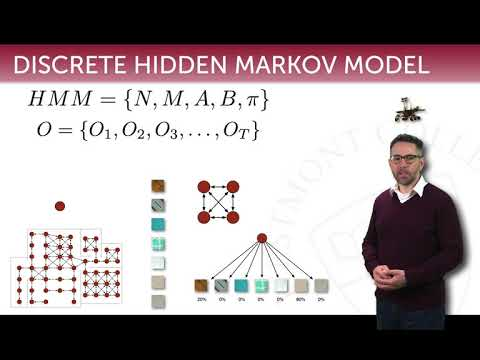

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('MPeedE6Odj0', width=800, height=300)

The following video provides nice description of the Viterbi algorithm

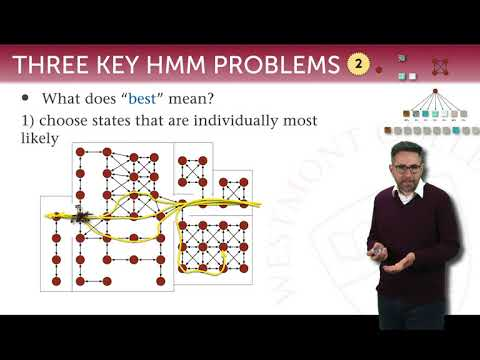

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('s9dU3sFeE40', width=800, height=300)

## <a name="refs"></a> References

1. Ethem Alpaydin, ```Introduction To Machine Learning, Second Edition```, MIT Press.
2. Viterbi algorithm, <a href="https://en.wikipedia.org/wiki/Viterbi_algorithm">Wikipedia</a>.